In [1]:
%cd "StressDetector-EEG-v2/"

/workspaces/Project_StressDetection/StressDetector-EEG-v2


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from torcheeg.datasets import DEAPDataset
from torcheeg import transforms
import torch
from src.utils.transforms import DeapAVToStress

from torcheeg.datasets.constants.emotion_recognition.deap import \
    DEAP_CHANNEL_LOCATION_DICT

dataset = DEAPDataset(
    io_path=f'../data_cache/deap',
    root_path='../DEAP/data_preprocessed_python-002/data_preprocessed_python',
    online_transform=transforms.Compose([
        transforms.To2d(),
        transforms.ToTensor()
    ]),
    label_transform=transforms.Compose([
        transforms.Select(['arousal','valence']),
        # transforms.Binary(5.0),
        # transforms.BinariesToCategory(),
        DeapAVToStress(thresholds=[
            [7.5, 2.5],
            [5.0, 5.0]]),
    ]),
    num_worker=8)

# dataset_label_names = ['LALV', 'LAHV', 'HALV', 'HAHV']

[2024-01-29 07:27:27] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../data_cache/deap.


In [3]:
dataset[1]

(tensor([[[  4.5394,   4.8771,   1.2011,  ...,  -5.3637,  -8.9537,  -7.1368],
          [  3.1196,   3.1612,  -0.7342,  ...,  -7.4487, -10.7008,  -7.7331],
          [  0.8641,   2.6748,   2.3525,  ...,  -7.1387,  -9.4880,  -7.2578],
          ...,
          [ -1.2643,  -4.4589,  -1.2664,  ...,  -2.4233,   0.3820,   2.6846],
          [ -4.3841,  -4.2601,  -2.9862,  ...,   1.7452,   5.2247,   4.3206],
          [ -0.1636,  -0.9272,  -1.7214,  ...,   1.6505,   5.3256,   6.6843]]]),
 0)

In [4]:
train_val_test_split = [0.6, 0.2, 0.2]

train_size = int(train_val_test_split[0] * len(dataset))
val_size = int(train_val_test_split[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [5]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
)

In [6]:
%cd "StressDetector-EEG-v2/"

[Errno 2] No such file or directory: 'StressDetector-EEG-v2/'
/workspaces/Project_StressDetection/StressDetector-EEG-v2


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [7]:
from torch.optim import SGD, Adam
from mmengine.runner import Runner
from src.models.torcheeg_mmwraper import MMTSCeption
from src.utils.metrics import AccuracyWithLoss, Accuracy, ConfusionMatrix


runner = Runner(
    # the model used for training and validation.
    # Needs to meet specific interface requirements

    model=MMTSCeption(
                num_classes=3,
                num_electrodes=32,
                sampling_rate=128,
                num_T=15,
                num_S=15,
                hid_channels=32,
                dropout=0.5).float(),

    # working directory which saves training logs and weight files
    work_dir='./.exp/new_deap_stress/tsception',
    
    # train dataloader needs to meet the PyTorch data loader protocol
    train_dataloader=train_loader,
    # optimize wrapper for optimization with additional features like
    # AMP, gradtient accumulation, etc
    optim_wrapper=dict(optimizer=dict(type=Adam, 
                                      lr=0.001,
                                      betas=(0.9, 0.999),
                                      eps=1e-08)),
    # trainging coinfs for specifying training epoches, verification intervals, etc
    train_cfg=dict(by_epoch=True, 
                   max_epochs=200, 
                   val_interval=1),
    
    
    # validation dataloader also needs to meet the PyTorch data loader protocol
    val_dataloader=val_loader,
    # validation configs for specifying additional parameters required for validation
    val_cfg=dict(),
    # validation evaluator. The default one is used here
    val_evaluator=dict(type=AccuracyWithLoss),

    # test dataloader also needs to meet the PyTorch data loader protocol
    test_dataloader=test_loader,
    # test configs for specifying additional parameters required for testing
    test_cfg=dict(),
    # test evaluator. The default one is used here
    test_evaluator=[dict(type=Accuracy), dict(type=ConfusionMatrix, num_classes=3)],

    visualizer=dict(type='Visualizer', vis_backends=[dict(type='TensorboardVisBackend')]),
    
    resume=True,
)

01/29 07:27:29 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 1629341685
    GPU 0: NVIDIA GeForce RTX 3060 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.1.2+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-ge

In [8]:
runner.train()

01/29 07:27:29 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in visualizer will be None.
01/29 07:27:29 - mmengine - WARNING - The prefix is not set in metric class AccuracyWithLoss.
01/29 07:27:29 - mmengine - WARNING - Dataset Subset has no metainfo. ``dataset_meta`` in evaluator, metric and visualizer will be None.
01/29 07:27:29 - mmengine - INFO - Auto resumed from the latest checkpoint /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/tsception/epoch_200.pth.
Loads checkpoint by local backend from path: /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/tsception/epoch_200.pth
01/29 07:27:29 - mmengine - INFO - Load checkpoint from /workspaces/Project_StressDetection/StressDetector-EEG-v2/.exp/new_deap_stress/tsception/epoch_200.pth
01/29 07:27:29 - mmengine - WARNING - `resume_param_scheduler` is True but `self.param_schedulers` is None, so skip resuming parameter schedulers
01/29 07:27:29 - mmeng

MMTSCeption(
  (data_preprocessor): BaseDataPreprocessor()
  (tsception): TSCeption(
    (Tception1): Sequential(
      (0): Conv2d(1, 15, kernel_size=(1, 64), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    )
    (Tception2): Sequential(
      (0): Conv2d(1, 15, kernel_size=(1, 32), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    )
    (Tception3): Sequential(
      (0): Conv2d(1, 15, kernel_size=(1, 16), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    )
    (Sception1): Sequential(
      (0): Conv2d(15, 15, kernel_size=(32, 1), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
    )
    (Sception2): Sequential(
      (0): Conv2d(15, 15, kernel_size=(16, 1), stride=(16, 1))
  

In [9]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


In [9]:
# Run trained model on test set
test_results = runner.test()

01/29 07:27:36 - mmengine - WARNING - The prefix is not set in metric class Accuracy.
01/29 07:27:36 - mmengine - INFO - Epoch(test) [ 10/240]    eta: 0:00:09  time: 0.0395  data_time: 0.0089  memory: 40  
01/29 07:27:36 - mmengine - INFO - Epoch(test) [ 20/240]    eta: 0:00:05  time: 0.0109  data_time: 0.0008  memory: 40  
01/29 07:27:37 - mmengine - INFO - Epoch(test) [ 30/240]    eta: 0:00:04  time: 0.0086  data_time: 0.0004  memory: 40  
01/29 07:27:37 - mmengine - INFO - Epoch(test) [ 40/240]    eta: 0:00:03  time: 0.0062  data_time: 0.0041  memory: 40  
01/29 07:27:37 - mmengine - INFO - Epoch(test) [ 50/240]    eta: 0:00:02  time: 0.0061  data_time: 0.0043  memory: 40  
01/29 07:27:37 - mmengine - INFO - Epoch(test) [ 60/240]    eta: 0:00:02  time: 0.0062  data_time: 0.0038  memory: 40  
01/29 07:27:37 - mmengine - INFO - Epoch(test) [ 70/240]    eta: 0:00:02  time: 0.0067  data_time: 0.0045  memory: 40  
01/29 07:27:37 - mmengine - INFO - Epoch(test) [ 80/240]    eta: 0:00:01  

In [10]:
test_results

{'accuracy': tensor(98.9323),
 'confusion_matrix/result': tensor([[11774,    62,    14],
         [   80,  3005,     0],
         [    6,     2,   417]])}

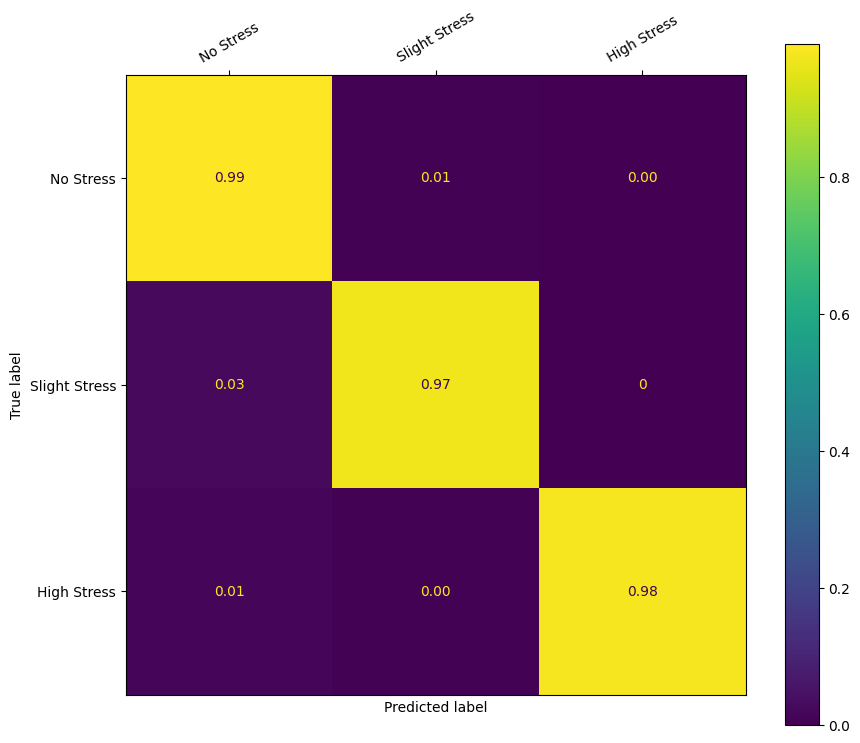

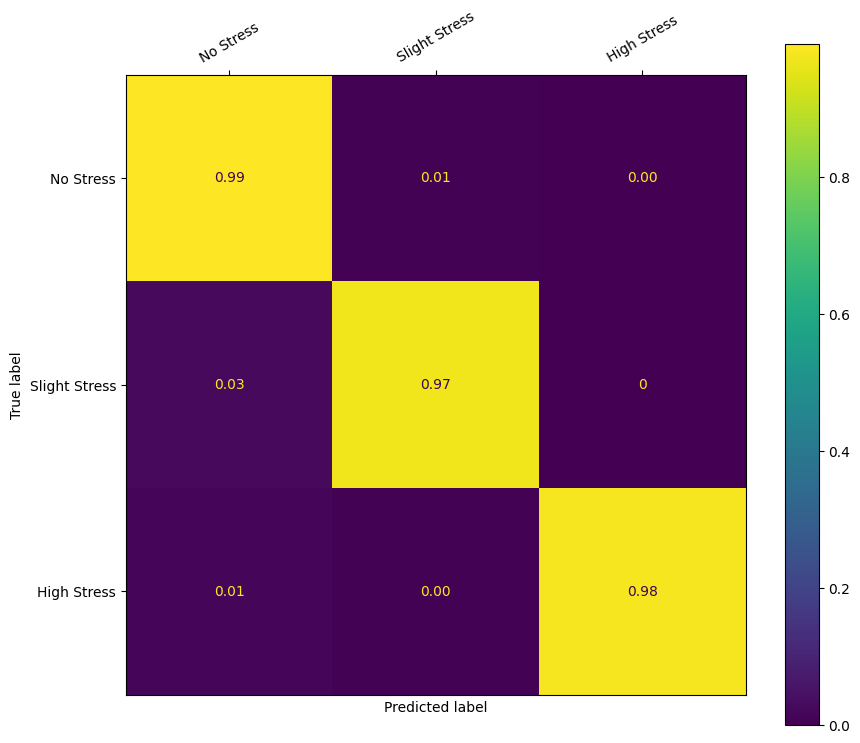

In [11]:
ConfusionMatrix().plot(test_results['confusion_matrix/result'], classes=['No Stress', 'Slight Stress', 'High Stress'], include_values=True, normalize=True)